In [1]:
from importlib.metadata import version
import torch

print("TORCH VERSION :", version("torch"))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backend.mps.is_available() else "cpu"
)
print("GPU  : ", device)

TORCH VERSION : 2.2.2
GPU  :  cuda


In [2]:
import torch.nn as nn
import math

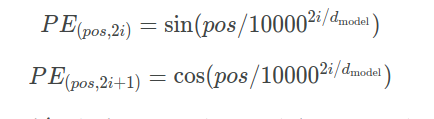

The exponential function of the natural logarithm of a number is just the number itself. 


x=exp(log(x))


exp(log(pos) - 2i/d_model.log(10000))
=>
exp(log(pos)) * exp(- 2i/d_model.log(10000))
=>
pos * exp(- 2i/d_model.log(10000)) # Ignore 2

where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000⋅2π. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of p_drop =0.1.



In [3]:
class PostionalEncoding(nn.Module):
    """
    Implementation of PE
    """

    def __init__(self, embedding_dim, max_len, dropout=0.1):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, embedding_dim)  # (max_len,embedding_dim)
        constant = math.log(10000)
        pos = torch.arange(0, max_len).unsqueeze(1)  # (max_len,1)
        # ignore multiplication with 2
        inv_den = torch.exp(
            (torch.arange(0, embedding_dim, 2, dtype=torch.float) / embedding_dim)
            * -constant
        )  # (embedding_dim/2)

        pe[:, 0::2] = torch.sin(pos * inv_den)  # (max_len,embedding_dim/2)
        pe[:, 1::2] = torch.cos(pos * inv_den)  # (max_len,embedding_dim/2)
        pe = pe.unsqueeze(0)  # (1,max_len,embedding_dim)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # here x will be the embedding vector    # (batch,seq_len,embedding_dim)
        x = x + self.pe[:, : x.shape[1], :].requires_grad_(False)
        return self.dropout(x)


# NOTE :
# register_buffer -
#     If you have parameters in your model, which should be saved and restored in the state_dict, but not trained by the optimizer, you should register them as buffers.
#     Buffers won’t be returned in model.parameters(), so that the optimizer won’t have a change to update them.

In [4]:
# eg:
embedding_dim, max_len = 16, 10
pe = PostionalEncoding(embedding_dim, max_len)
# inp = torch.randint(0,10,(1,max_len,embedding_dim))
inp = torch.zeros(1, max_len, embedding_dim)
result = pe(inp)

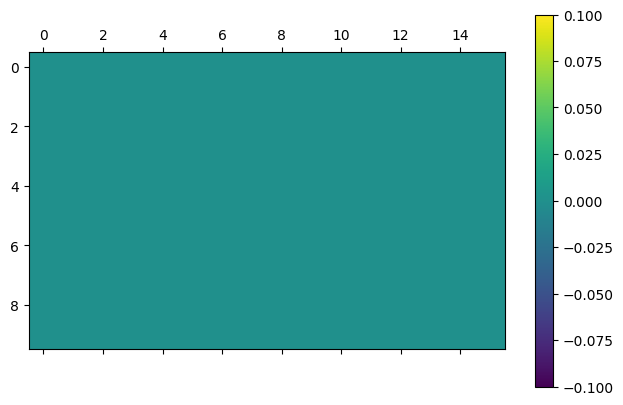

In [5]:
import matplotlib.pyplot as plt

cax = plt.matshow(inp.squeeze(0))
plt.gcf().colorbar(cax)

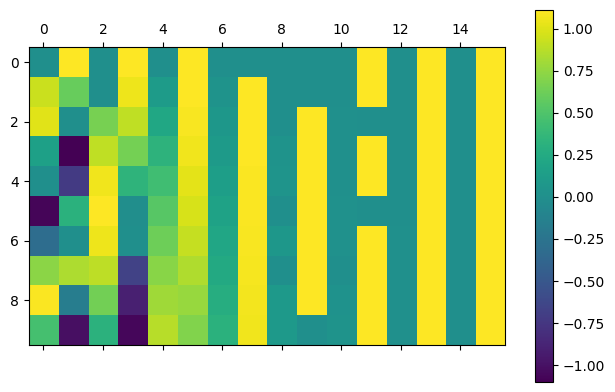

In [6]:
import matplotlib.pyplot as plt

cax = plt.matshow(result.squeeze(0))
plt.gcf().colorbar(cax)

In [7]:
# Rotary POstion Embedding
# Ref : https://www.cuemath.com/algebra/rotation-matrix/
# https://medium.com/@ngiengkianyew/understanding-rotary-positional-encoding-40635a4d078e

In [114]:
from typing import Union, Tuple


class RotaryEmbedding(nn.Module):
    """
    [Rotary positional embeddings (RoPE)](https://arxiv.org/abs/2104.09864).
    """

    def __init__(
        self,
        h_dim: int,
        seq_len: int,
        base: Union[int, float] = 10000,
        device: str = None,
        scaling_factor: Union[int, float] = 1.0,
    ):
        super().__init__()

        # Long-termdecay: θi=10000**−2i/d.
        theta = 1.0 / base ** (
            torch.arange(0, h_dim, 2, dtype=torch.int16, device=device) / h_dim
        )  #  (h_dim/2)
        m = torch.arange(seq_len, dtype=torch.int16, device=device).type_as(
            theta
        )  #  (seq_len)
        m /= scaling_factor
        m0 = torch.outer(m, theta)  # (seq_len,h_dim/2)
        self.m0 = torch.polar(torch.ones_like(m0), m0)  # e^i0 = cos0 +isin0

    def forward(self, x: torch.Tensor):

        x_complex = torch.view_as_complex(
            x.float().reshape(*x.shape[:-1], -1, 2)
        )  # (b,seq_len,d_model,head,head_dim/2,2)
        m0_transform = self.m0.unsqueeze(0).unsqueeze(
            2
        )  # (seq_len,h_dim/2) -> (1,seq_len,1,h_dim/2)
        x_rotated = x_complex * m0_transform  # (b,seq_len,d_model,head,head_dim/2,2)
        x_out = torch.view_as_real(x_rotated)
        return x_out.reshape(*x.shape)

In [141]:
# (batch_size, seq_len, h, d_k) -
x = torch.rand(16, 1024, 8, 64)
m = RotaryEmbedding(64, 1024)  # (x)

In [143]:
m.m0.shape

torch.Size([1024, 32])

In [145]:
m.m0.unsqueeze(0).shape

torch.Size([1, 1024, 32])